In [1]:
!pip install umap-learn
!pip install resemblyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)

In [43]:
from resemblyzer import preprocess_wav, VoiceEncoder
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from resemblyzer import sampling_rate
from matplotlib import cm
from time import sleep, perf_counter as timer
from umap import UMAP
from sys import stderr
import matplotlib.pyplot as plt

In [44]:
_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
_my_colors = np.array([
    [0, 127, 70],
    [255, 0, 0],
    [255, 217, 38],
    [0, 135, 255],
    [165, 0, 165],
    [255, 167, 255],
    [97, 142, 151],
    [0, 255, 255],
    [255, 96, 38],
    [142, 76, 0],
    [33, 0, 127],
    [0, 0, 0],
    [183, 183, 183],
    [76, 255, 0],
], dtype=float) / 255


def play_wav(wav, blocking=True):
    try:
        import sounddevice as sd
        # Small bug with sounddevice.play: the audio is cut 0.5 second too early. We pad it to
        # make up for that
        wav = np.concatenate((wav, np.zeros(sampling_rate // 2)))
        sd.play(wav, sampling_rate, blocking=blocking)
    except Exception as e:
        print("Failed to play audio: %s" % repr(e))


def plot_similarity_matrix(matrix, labels_a=None, labels_b=None, ax: plt.Axes=None, title=""):
    if ax is None:
        _, ax = plt.subplots()
    fig = plt.gcf()

    img = ax.matshow(matrix, extent=(-0.5, matrix.shape[0] - 0.5,
                                     -0.5, matrix.shape[1] - 0.5))

    ax.xaxis.set_ticks_position("bottom")
    if labels_a is not None:
        ax.set_xticks(range(len(labels_a)))
        ax.set_xticklabels(labels_a, rotation=90)
    if labels_b is not None:
        ax.set_yticks(range(len(labels_b)))
        ax.set_yticklabels(labels_b[::-1])  # Upper origin -> reverse y axis
    ax.set_title(title)

    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15)
    fig.colorbar(img, cax=cax, ticks=np.linspace(0.4, 1, 7))
    img.set_clim(0.4, 1)
    img.set_cmap("inferno")

    return ax


def plot_histograms(all_samples, ax=None, names=None, title=""):
    """
    Plots (possibly) overlapping histograms and their median
    """
    if ax is None:
        _, ax = plt.subplots()

    for samples, color, name in zip(all_samples, _default_colors, names):
        ax.hist(samples, density=True, color=color + "80", label=name)
    ax.legend()
    ax.set_xlim(0.35, 1)
    ax.set_yticks([])
    ax.set_title(title)

    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)      # Yeah, I know
    for samples, color in zip(all_samples, _default_colors):
        median = np.median(samples)
        ax.vlines(median, *ylim, color, "dashed")
        ax.text(median, ylim[1] * 0.15, "median", rotation=270, color=color)

    return ax
from sklearn.preprocessing import MinMaxScaler

def plot_projections(embeds, speakers, ax=None, colors=None, markers=None, legend=False,
                     title="",xlabel="$x_0$", ylabel="$x_1$", **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))

    # Compute the 2D projections. You could also project to another number of dimensions (e.g.
    # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
    reducer = UMAP(**kwargs)
    projs = reducer.fit_transform(embeds)
    scaler = MinMaxScaler()
    projs = scaler.fit_transform(projs)

    unique_speakers = np.unique(speakers) # Ensure uniqueness
    num_speakers = len(unique_speakers)
    # Generate distinct colors
    _my_colors = plt.cm.jet(np.linspace(0, 1, num_speakers))

    # Draw the projections
    speakers = np.array(speakers)

    colors = colors or _my_colors
    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]
        marker = "o" if markers is None else markers[i]
        label = speaker if legend else None
        ax.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label)

    if legend:
        ax.legend(title="Speakers", ncol=2)
    # ax.set_title(title, fontsize=30)
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_aspect("equal")

    if title != "":
        safe_title = title.replace('/', '-').replace('\\', '-')
        plt.savefig(f"/content/drive/MyDrive/cs679_project_compare_40/code/compare_graphs/speaker_embedding/{safe_title}.png")

    return projs


def interactive_diarization(similarity_dict, wav, wav_splits, x_crop=5, show_time=False):
    fig, ax = plt.subplots()
    lines = [ax.plot([], [], label=name)[0] for name in similarity_dict.keys()]
    text = ax.text(0, 0, "", fontsize=10)

    def init():
        ax.set_ylim(0.4, 1)
        ax.set_ylabel("Similarity")
        if show_time:
            ax.set_xlabel("Time (seconds)")
        else:
            ax.set_xticks([])
        ax.set_title("Diarization")
        ax.legend(loc="lower right")
        return lines + [text]

    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    rate = 1 / (times[1] - times[0])
    crop_range = int(np.round(x_crop * rate))
    ticks = np.arange(0, len(wav_splits), rate)
    ref_time = timer()

    def update(i):
        # Crop plot
        crop = (max(i - crop_range // 2, 0), i + crop_range // 2)
        ax.set_xlim(i - crop_range // 2, crop[1])
        if show_time:
            crop_ticks = ticks[(crop[0] <= ticks) * (ticks <= crop[1])]
            ax.set_xticks(crop_ticks)
            ax.set_xticklabels(np.round(crop_ticks / rate).astype(np.int))

        # Plot the prediction
        similarities = [s[i] for s in similarity_dict.values()]
        best = np.argmax(similarities)
        name, similarity = list(similarity_dict.keys())[best], similarities[best]
        if similarity > 0.75:
            message = "Speaker: %s (confident)" % name
            color = _default_colors[best]
        elif similarity > 0.65:
            message = "Speaker: %s (uncertain)" % name
            color = _default_colors[best]
        else:
            message = "Unknown/No speaker"
            color = "black"
        text.set_text(message)
        text.set_c(color)
        text.set_position((i, 0.96))

        # Plot data
        for line, (name, similarities) in zip(lines, similarity_dict.items()):
            line.set_data(range(crop[0], i + 1), similarities[crop[0]:i + 1])

        # Block to synchronize with the audio (interval is not reliable)
        current_time = timer() - ref_time
        if current_time < times[i]:
            sleep(times[i] - current_time)
        elif current_time - 0.2 > times[i]:
            print("Animation is delayed further than 200ms!", file=stderr)
        return lines + [text]

    ani = FuncAnimation(fig, update, frames=len(wav_splits), init_func=init, blit=not show_time,
                        repeat=False, interval=1)
    play_wav(wav, blocking=False)
    plt.show()


def plot_embedding_as_heatmap(embed, ax=None, title="", shape=None, color_range=(0, 0.30)):
    if ax is None:
        _, ax = plt.subplots()

    if shape is None:
        height = int(np.sqrt(len(embed)))
        shape = (height, -1)
    embed = embed.reshape(shape)

    cmap = cm.get_cmap()
    mappable = ax.imshow(embed, cmap=cmap)
    cbar = plt.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_clim(*color_range)

    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(title)

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
wav_fpaths = list(Path("/content/drive/MyDrive/cs679_project_compare_40/wavs").glob("**/*.wav"))

In [47]:
import pickle

array([[0.3322258 , 0.703694  ],
       [0.07868171, 0.91159856],
       [0.16468856, 0.74162865],
       [0.84844214, 0.27510273],
       [0.91793257, 0.4140141 ],
       [0.94652504, 0.24859142],
       [0.7382442 , 0.41536498],
       [0.19535938, 0.6288842 ],
       [0.99999994, 0.19857216],
       [0.8556207 , 0.1555978 ],
       [0.9176555 , 0.02941537],
       [0.26217803, 0.81574285],
       [0.86617464, 0.        ],
       [0.90617937, 0.35194468],
       [0.9005262 , 0.1709851 ],
       [0.19863907, 0.7836257 ],
       [0.05647086, 0.8685595 ],
       [0.78022593, 0.34236133],
       [0.17820585, 0.968019  ],
       [0.2615826 , 0.7453548 ],
       [0.03029683, 0.8140744 ],
       [0.83291245, 0.06649435],
       [0.7497567 , 0.3167863 ],
       [0.7611619 , 0.22699308],
       [0.04907735, 0.96349216],
       [0.1396069 , 0.65720856],
       [0.939617  , 0.10254395],
       [0.15897334, 1.        ],
       [0.14282247, 0.8967253 ],
       [0.19641116, 0.8717389 ],
       [0.

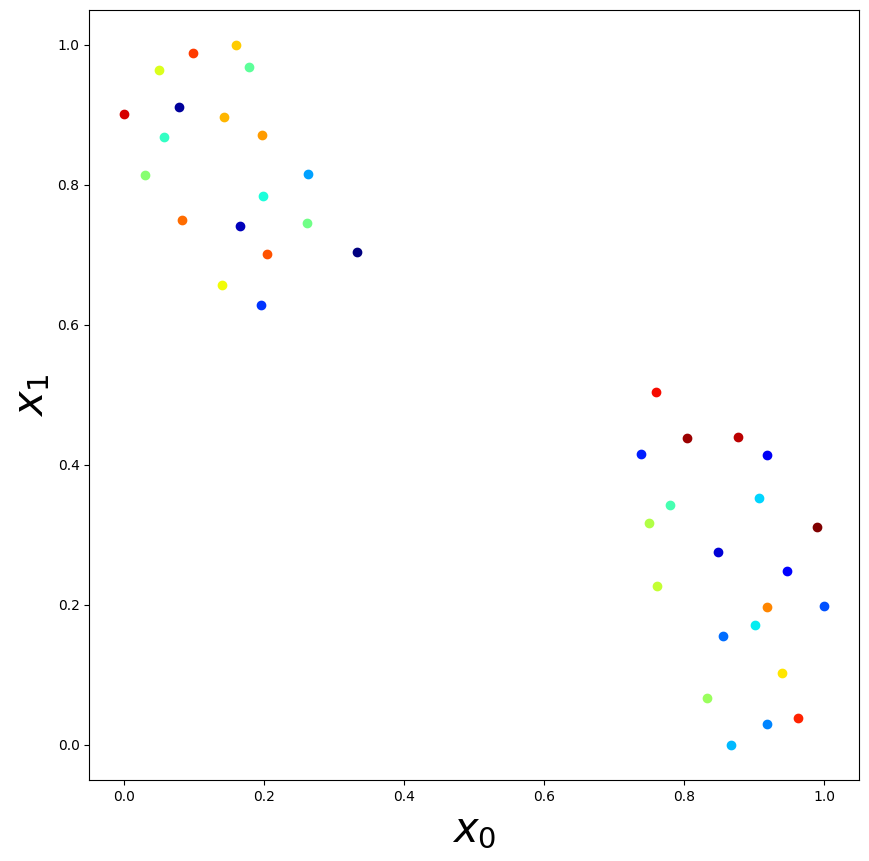

In [48]:
# below are default

with open('/content/drive/MyDrive/cs679_project_compare_40/code/compare_graphs/metadata_pkls/metadata.pkl', 'rb') as f:
    loaded_train = pickle.load(f)

speaker_embeds_train = []
speaker_train = []
for data in loaded_train:
    speaker_train.append(data[0])
    speaker_embeds_train.append(data[1])

plot_projections(speaker_embeds_train, speaker_train, title="Speaker Projections Original")

array([[0.7244258 , 0.25200862],
       [0.48983192, 0.6777463 ],
       [0.47701597, 0.8637762 ],
       [0.12099814, 0.2408427 ],
       [0.350008  , 0.83493495],
       [0.9234204 , 0.45298737],
       [0.5954938 , 0.17413294],
       [0.4454503 , 0.5426092 ],
       [0.        , 0.51103926],
       [0.48160172, 0.0437144 ],
       [0.23655438, 0.48851675],
       [0.93798447, 0.23004806],
       [0.19273567, 0.7294062 ],
       [0.77506065, 0.38994253],
       [0.8441739 , 0.74418736],
       [0.08446765, 0.83910704],
       [0.6340599 , 0.8092313 ],
       [0.6223321 , 0.6619887 ],
       [0.11393881, 0.3473702 ],
       [0.4448042 , 1.        ],
       [0.7630749 , 0.1234889 ],
       [0.0340867 , 0.64515567],
       [0.6955323 , 0.5671762 ],
       [0.75631475, 0.60021996],
       [0.50236607, 0.252828  ],
       [0.6662626 , 0.3515942 ],
       [0.28118587, 0.5490798 ],
       [0.33212614, 0.22771108],
       [0.9324112 , 0.686736  ],
       [0.38754368, 0.32833296],
       [0.

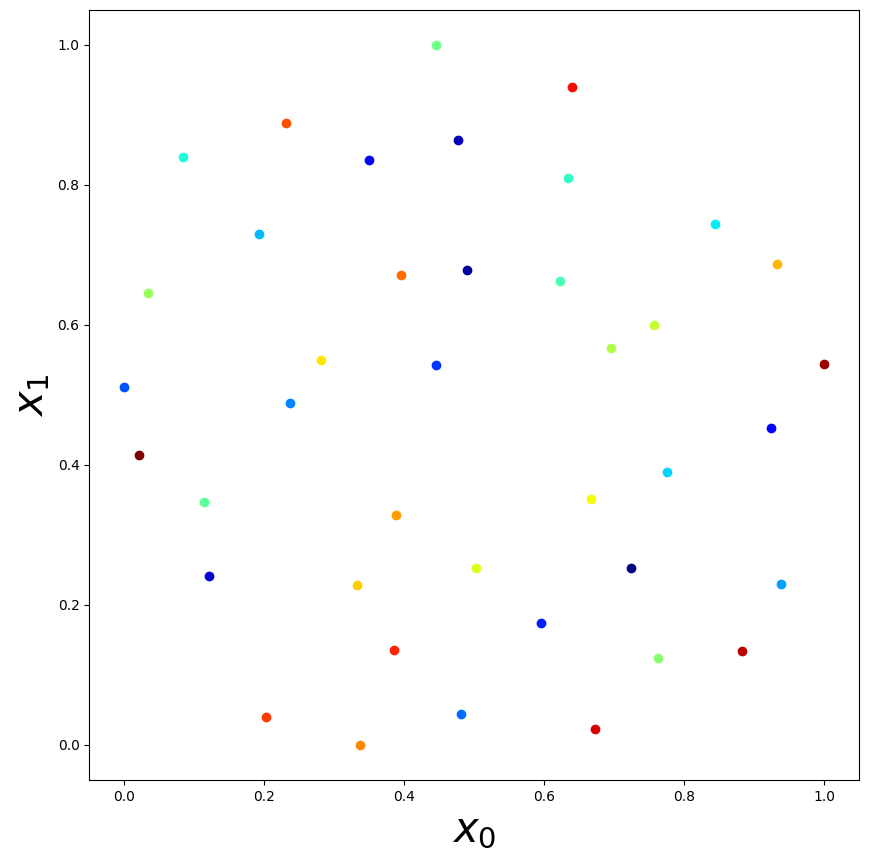

In [49]:
with open('/content/drive/MyDrive/cs679_project_compare_40/code/compare_graphs/metadata_pkls/metadata_facebook.pkl', 'rb') as f:
    loaded_train = pickle.load(f)

speaker_embeds_train = []
speaker_train = []
for data in loaded_train:
    speaker_train.append(data[0])
    speaker_embeds_train.append(data[1])

plot_projections(speaker_embeds_train, speaker_train, title="Speaker Projections Facebook")

array([[0.5239849 , 0.79892534],
       [0.6063831 , 0.43036184],
       [0.37790656, 0.5046308 ],
       [0.86203146, 0.46660492],
       [0.49510455, 0.50521797],
       [0.45411396, 0.18324238],
       [0.6032524 , 0.13341889],
       [0.67670274, 0.3192549 ],
       [0.21617532, 0.79364747],
       [0.74329925, 0.53832597],
       [0.3576026 , 0.6805428 ],
       [0.0433774 , 0.5974392 ],
       [0.97344875, 0.272894  ],
       [0.74349904, 0.6058542 ],
       [0.6173153 , 0.59064704],
       [0.19818258, 0.6409592 ],
       [0.10959888, 0.5330816 ],
       [0.24080157, 0.44917426],
       [0.8792701 , 0.11211266],
       [0.11279678, 0.26539552],
       [0.3240621 , 0.17801392],
       [0.23610163, 0.06694352],
       [0.46468163, 0.04867815],
       [0.792073  , 0.22267807],
       [0.7113583 , 0.        ],
       [0.5439706 , 0.9317722 ],
       [0.37843013, 0.3628179 ],
       [0.08025861, 0.7949539 ],
       [0.2687869 , 0.26122352],
       [1.        , 0.36648646],
       [0.

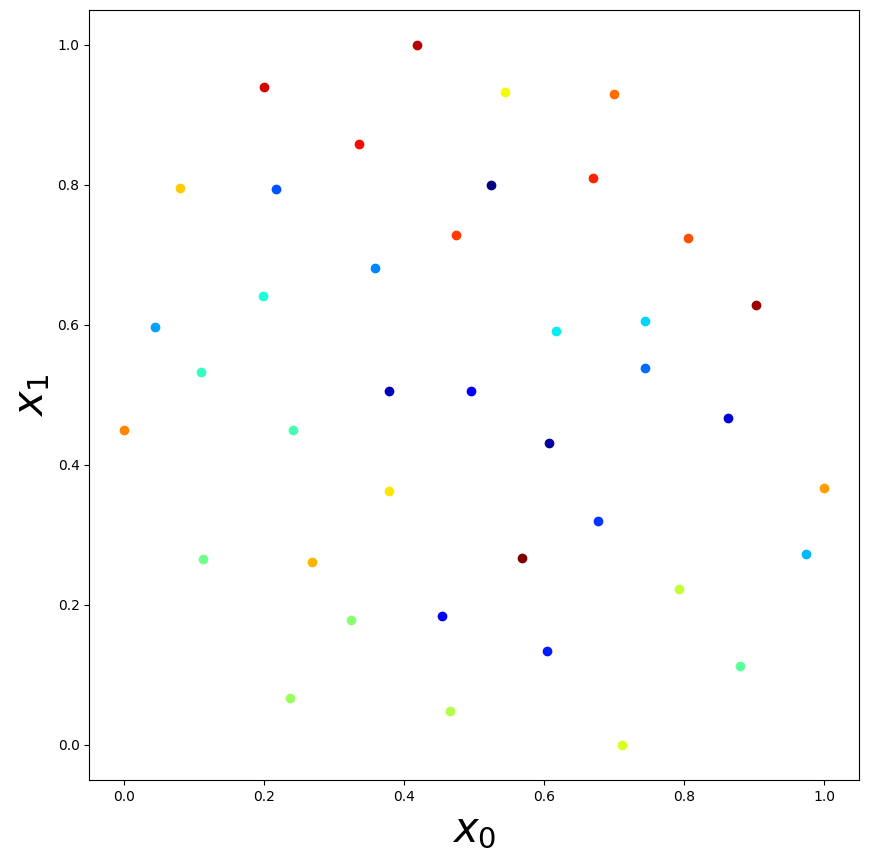

In [50]:
with open('/content/drive/MyDrive/cs679_project_compare_40/code/compare_graphs/metadata_pkls/metadata_speechbrain.pkl', 'rb') as f:
    loaded_train = pickle.load(f)

speaker_embeds_train = []
speaker_train = []
for data in loaded_train:
    speaker_train.append(data[0])
    speaker_embeds_train.append(data[1])

plot_projections(speaker_embeds_train, speaker_train, title="Speaker Projections Speechbrain")

array([[0.5165367 , 0.56975615],
       [0.10784891, 0.7474911 ],
       [0.12981859, 0.9924759 ],
       [0.87777996, 0.49872005],
       [0.65555453, 0.43344712],
       [0.872326  , 0.17762375],
       [0.72301495, 0.60084105],
       [0.01578653, 0.8194489 ],
       [0.6998919 , 0.16354346],
       [0.9472524 , 0.16255212],
       [0.66090107, 0.        ],
       [0.19500086, 0.5499836 ],
       [0.77401674, 0.23234332],
       [0.67313194, 0.31092918],
       [0.86019564, 0.07424212],
       [0.        , 0.9283542 ],
       [0.15666229, 0.63431644],
       [0.9023597 , 0.47256827],
       [0.29885748, 0.6247989 ],
       [0.06822601, 0.83235556],
       [0.38822982, 0.61842346],
       [0.8826479 , 0.30904055],
       [0.7676861 , 0.49330497],
       [0.78444386, 0.38086236],
       [0.37819567, 0.7546521 ],
       [0.05886355, 0.99999994],
       [0.9861467 , 0.3451512 ],
       [0.3376477 , 0.8077017 ],
       [0.46377823, 0.6650379 ],
       [0.2819911 , 0.8960876 ],
       [1.

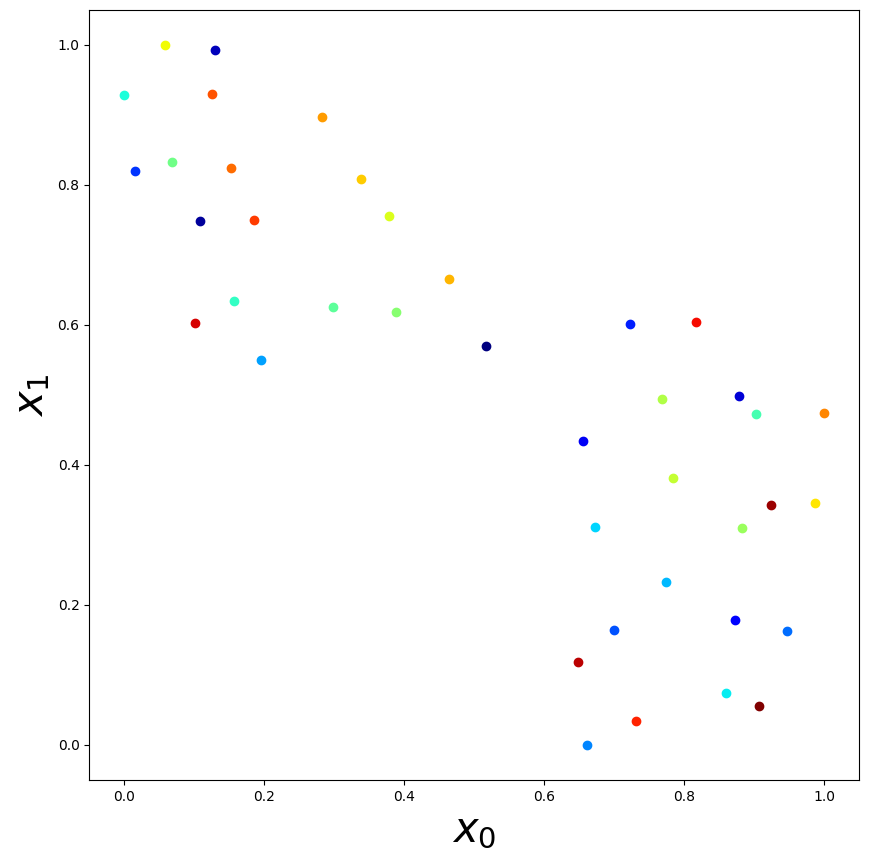

In [51]:
with open('/content/drive/MyDrive/cs679_project_compare_40/code/compare_graphs/metadata_pkls/train_with_convgru_embedder.pkl', 'rb') as f:
    loaded_train = pickle.load(f)

speaker_embeds_train = []
speaker_train = []
for data in loaded_train:
    speaker_train.append(data[0])
    speaker_embeds_train.append(data[1])

plot_projections(speaker_embeds_train, speaker_train, title="Speaker Projections ConvGRU")